<a href="https://www.kaggle.com/code/davidecortonesi/wallmart-s-sales-forecasting?scriptVersionId=152146495" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/walmart-dataset/Walmart.csv


In [2]:
df = pd.read_csv("/kaggle/input/walmart-dataset/Walmart.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


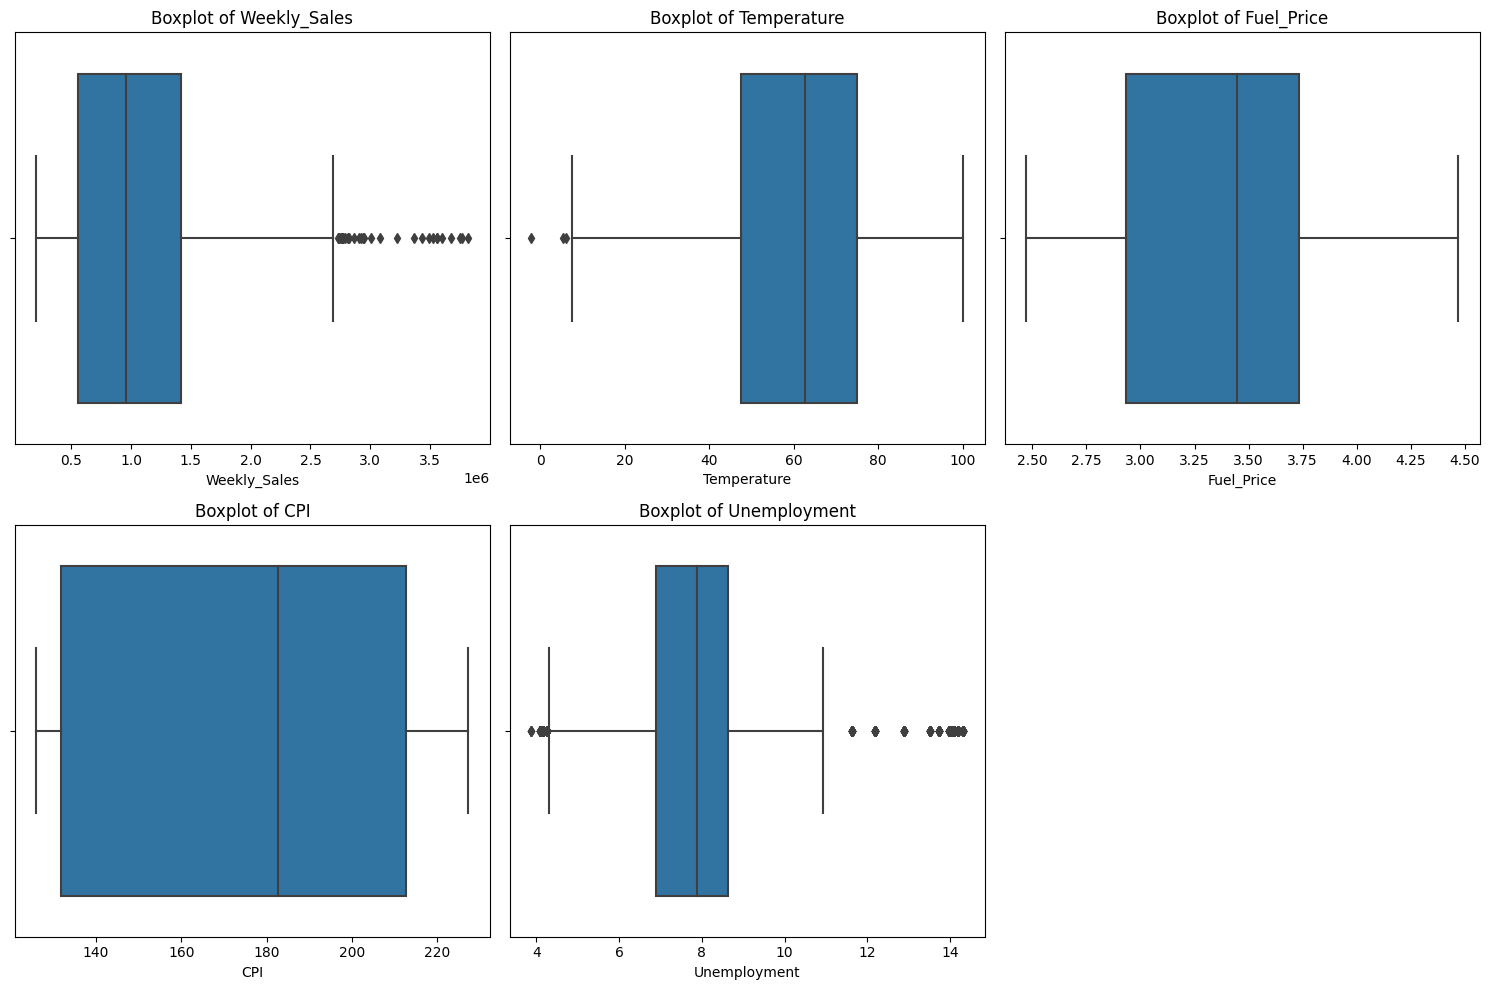

In [3]:
columns_to_plot = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]

# Create 5 separate boxplots
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)  # TO DETERMINE THE ORDER OF ROWS AND COLUMNS TO ARRANGE GRAPHS
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()


In [4]:
# Function for removing outliers in specified columns
def outlier_removal(data, columns):
    # Iterate over specified columns for outlier removal
    for column in columns:
        # Calculate the first quartile (Q1)
        Q1 = data[column].quantile(0.25)
        # Calculate the third quartile (Q3)
        Q3 = data[column].quantile(0.75)
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        # Define the upper limit for outliers
        upper_limit = Q3 + 1.5 * IQR
        # Define the lower limit for outliers
        lower_limit = Q1 - 1.5 * IQR
        # Clip values beyond the upper and lower limits
        data[column] = np.clip(data[column], lower_limit, upper_limit)

# Call the function with list of columns to process
columns_to_process = ["Weekly_Sales", "Temperature", "Unemployment"]
outlier_removal(df, columns_to_process)

In [5]:
# Define the date format
date_format = "%d-%m-%Y"

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format=date_format)

# Extract day, week, month, and year information from the 'Date' column
df['Day'] = df['Date'].dt.day
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Remove the original 'Date' column
df.drop('Date', axis=1, inplace=True)

In [6]:
# Separate features (X) and target variable (y)
x = df.drop(['Weekly_Sales'], axis=1)
y = df['Weekly_Sales']

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the features
x_scaled = scaler.fit_transform(x)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=67)

In [7]:
#IMPORT LIBRARIES FOR FORECASTING MODELS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

---------------------
Model: Decision Tree
---------------------
MSE: 14664248180.819462
MAE: 62361.77491064491
R2 : 95.44 %
---------------------
Model: ElasticNet
---------------------
MSE: 282990146629.4809
MAE: 444865.55964178935
R2 : 12.04 %
---------------------
Model: Gradient Boosting
---------------------
MSE: 32213349370.52655
MAE: 136486.05180004187
R2 : 89.99 %
---------------------
Model: K-Nearest Neighbors
---------------------
MSE: 199717685688.85733
MAE: 340325.36467987567
R2 : 37.93 %
---------------------
Model: Lasso
---------------------
MSE: 278156511944.7029
MAE: 438849.0320861846
R2 : 13.55 %
---------------------
Model: Linear Regression
---------------------
MSE: 278618277648.77673
MAE: 439147.98264133837
R2 : 13.4 %
---------------------
Model: Random Forest
---------------------
MSE: 9034134435.33951
MAE: 51335.96957060993
R2 : 97.19 %
---------------------
Model: Ridge
---------------------
MSE: 278175682454.5771
MAE: 438859.49405159446
R2 : 13.54 %
-------

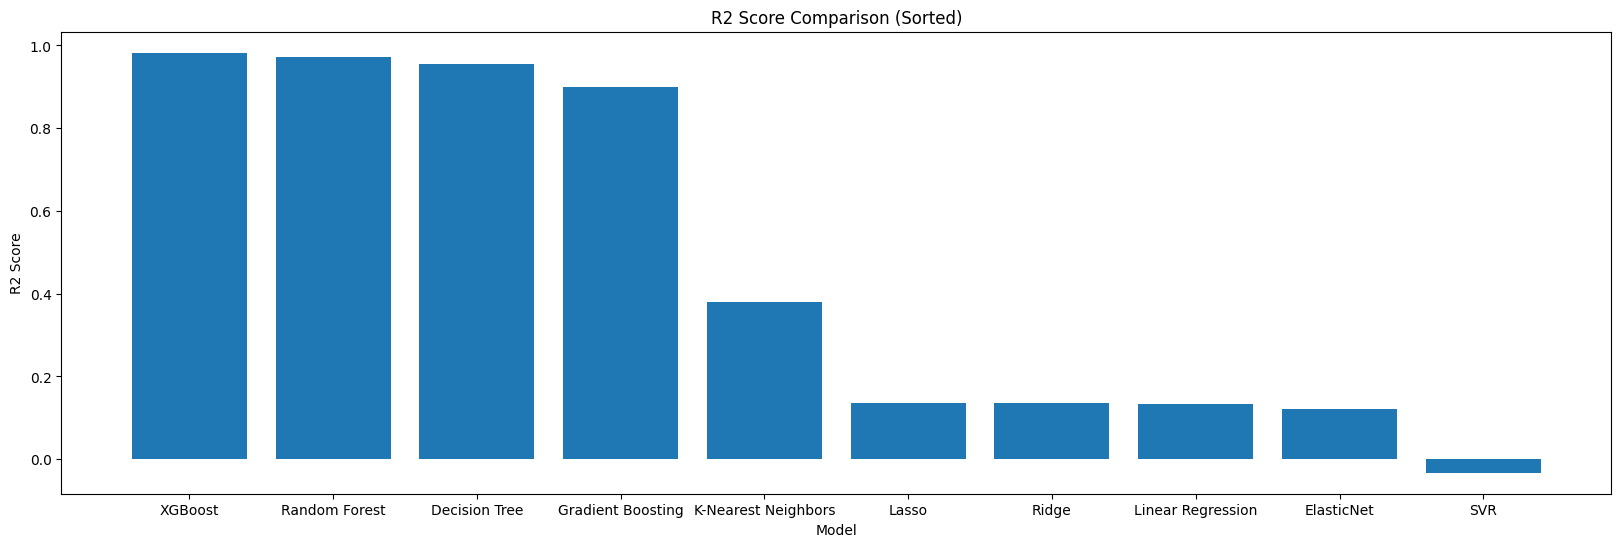

In [8]:
def model_evaluation(y_test, y_train, x_test, x_train, model, model_name):
    # Instantiate the model
    model_instance = model()
    # Fit the model on the training data
    model_instance.fit(x_train, y_train)
    # Predict on the test data
    y_pred = model_instance.predict(x_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Display evaluation results
    print('---------------------')
    print(f'Model: {model_name}')
    print('---------------------')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R2 : {round(r2 * 100, 2)} %')
    
    return mse, mae, r2

def compare_models(x_train, x_test, y_train, y_test, models):
    results = {'Model': [], 'MSE': [], 'MAE': [], 'R2': []}

    for model_name, model in models.items():
        # Evaluate each model and retrieve metrics
        mse, mae, r2 = model_evaluation(y_test, y_train, x_test, x_train, model, model_name)
        
        # Append results to the dictionary
        results['Model'].append(model_name)
        results['MSE'].append(mse)
        results['MAE'].append(mae)
        results['R2'].append(r2)
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    # Sort the DataFrame based on R2 scores in descending order
    results_df_sorted = results_df.sort_values(by='R2', ascending=False)
    
    # Plotting the R2 scores
    plt.figure(figsize=(20, 6))
    plt.bar(results_df_sorted['Model'], results_df_sorted['R2'])
    plt.title('R2 Score Comparison (Sorted)')
    plt.xlabel('Model')
    plt.ylabel('R2 Score')
    plt.show()
    
    return results_df_sorted

# Definition of models
models = {
    'Decision Tree': DecisionTreeRegressor,
    'ElasticNet': ElasticNet,
    'Gradient Boosting': GradientBoostingRegressor,
    'K-Nearest Neighbors': KNeighborsRegressor,
    'Lasso': Lasso,
    'Linear Regression': LinearRegression,
    'Random Forest': RandomForestRegressor,
    'Ridge': Ridge,
    'SVR': SVR,
    'XGBoost': xgb.XGBRegressor,
}

# Call the function to compare models
results_df_sorted = compare_models(x_train, x_test, y_train, y_test, models)

      Real Values  Predicted Values   Difference
4036    463752.89      4.866063e+05 -22853.39125
6099    628115.61      5.922254e+05  35890.23500
5373    416953.51      4.380928e+05 -21139.33375
4501   1175447.49      1.147101e+06  28346.61500
5908    537455.65      6.100871e+05 -72631.47500
2632   1257972.37      1.307680e+06 -49707.88000
6021    672062.08      6.573730e+05  14689.08000
4699    290444.31      2.816632e+05   8781.09125
4225    431798.64      4.342355e+05  -2436.86000
4186    484661.87      4.262666e+05  58395.24500


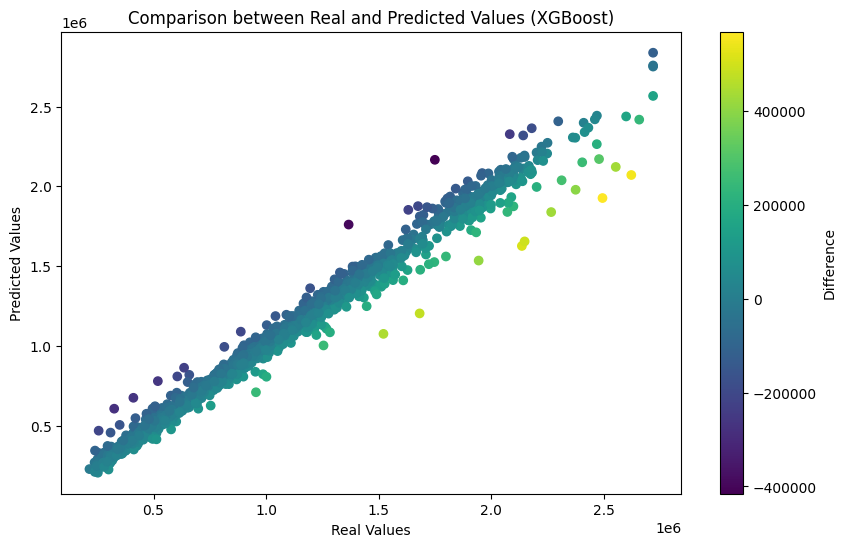

In [9]:
# Create an XGBoost regressor model and fit it on the training data
xgb_model = xgb.XGBRegressor()
xgb_model.fit(x_train, y_train)

# Predict on the test data using the XGBoost model
y_pred_xgb = xgb_model.predict(x_test)

# Comparison between actual and predicted values for the XGBoost model
comparison_xgb_df = pd.DataFrame({'Real Values': y_test, 'Predicted Values': y_pred_xgb})

# Add a "Difference" column to the DataFrame
comparison_xgb_df['Difference'] = comparison_xgb_df['Real Values'] - comparison_xgb_df['Predicted Values']

# Display the first 10 records of the comparison DataFrame for the XGBoost model
print(comparison_xgb_df.head(10))

# Plot the differences between actual and predicted values for the XGBoost model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, c=comparison_xgb_df['Difference'], cmap='viridis')
plt.colorbar(label='Difference')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Comparison between Real and Predicted Values (XGBoost)')
plt.show()

# Reset the formatting option to the default (scientific notation)
pd.reset_option('display.float_format')